In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Foolbox
import foolbox as fb
from foolbox import PyTorchModel
from foolbox.attacks import LinfPGD, FGSM, L0BrendelBethgeAttack, L1BrendelBethgeAttack, L2CarliniWagnerAttack

# Custom modules
from utils import compute_confusion_matrix

In [23]:
# Move everything to the GPU if possible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### CONFIG
save_path = "models" + os.sep + "CIFAR-10" + os.sep

#attack, attack_kwargs = L0BrendelBethgeAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = L1BrendelBethgeAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = L2CarliniWagnerAttack(steps=20), {"epsilons": None}
#attack, attack_kwargs = FGSM(), {"epsilons": 0.01}
attack, attack_kwargs = LinfPGD(), {"epsilons": 0.1}
print(attack_kwargs)    

# Load model and move everything to GPU if possible
model = torch.load(save_path + 'reference_model_val_acc=0.8023.pt', 
                   map_location=device)
model.eval()


# Preparing dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=1)])
testset = CIFAR10(root='./data', download=True, train=False, transform=transform,)
kwargs = {
    "batch_size": 100, "pin_memory": True, "num_workers": 4,
}
dataloader = DataLoader(testset, **kwargs)

fmodel = PyTorchModel(model, bounds=(-0.5,0.5)) 

images, labels = next(iter(dataloader))
images, labels = images.to(device), labels.to(device) 

# Attack
_, clipped_advs, success = attack(fmodel, images, labels, **attack_kwargs)

print("Done")

{'epsilons': 0.1}
Files already downloaded and verified
Done


In [24]:
# Did the attack on this batch succeed?
success

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

In [25]:
# Predictions
prediction = model(clipped_advs).argmax(dim=1)

# Convert images to the correct format for plotting.
adversarial_examples = clipped_advs.permute(0, 2, 3, 1) + 0.5
original_images = images.permute(0, 2, 3, 1) + 0.5
difference = original_images-adversarial_examples

# For CIFAR-10
names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

tensor(True, device='cuda:0')


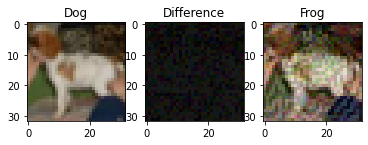

In [31]:
k = 12
fig, axes =  plt.subplots(1,3)

axes[0].imshow(original_images[k].cpu())
axes[1].imshow(np.abs(difference[k].cpu()))
axes[2].imshow(adversarial_examples[k].cpu())

axes[0].set_title(f"{names[labels[k]]}")
axes[1].set_title("Difference")
axes[2].set_title(f"{names[prediction[k]]}")

print(success[k])